<a href="https://colab.research.google.com/github/VincentHans/Dynamic-Programming/blob/master/2_DP_environements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 767 Winter 2020 Assignment 1
   
Nadhir Hassen (ID: )

Yasmine Doumouchel (ID: )


**EMAIL:**    
nadhir.hassen@mail.mcgill.ca   
yasmine.dumouchel@mail.mcgill.ca


# CODING-Question 1. Explore-Exploit in Bandits 

# TRACK A:

Implement Boltzmann (softmax) exploration, the UCB algorithm and Thompson sampling algorithm

In [152]:
####YOUR CODE HERE

time: 2.21 ms


# CODING-Question 2. Dynamic Programming

(Frozen Lake and Taxi environment)  



# TRACK A:
Implement tabular policy iteration and value iteration to find the optimal value function and optimal policy.

In [0]:
!pip install ipython-autotime
%load_ext autotime
!pip install gym

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from copy import copy
import gym




def policy_evaluation(policy,values, env,tol, gamma=0.9,steps=1):

  for state in range(steps):
    delta = 0
    for state in range(env.observation_space.n):
      new_value = copy(values[state])
      _values = []

      for pi,prob in policy[state]:
        if prob > 0:
          _values.append(np.sum([pi * (rew + gamma * values[nexts])\
                                  for pi, nexts, rew, _ in env.env.P[state][pi]]))
      values[state] = np.sum(_values)

      if abs(new_value-values[state]) > delta:
        delta = abs(new_value-values[state])
    
    if delta < tol:
      break

  return values

def find_max(a):
  return np.where(a != np.max(a))[0]

def policy_improvement(policy,values,env,gamma=0.9):
    policy_converge = True

    for state in range(env.observation_space.n):
      new_value = np.copy(policy[state])
      _values = []
      actions_len = env.action_space.n
      for action in range(actions_len):
        _values.append(np.sum([p * (rew + gamma * values[nexts])\
                                 for p, nexts, rew, _ in env.env.P[state][action]]))
      max_temp = find_max(_values)
      policy[state] = np.array([(i[0],1/(actions_len -len(max_temp))) for i in policy[state]])
      for i in max_temp:
        policy[state][i] = (i,0)

      if not np.array_equal(new_value, policy[state]):
        policy_converge = False
    
    return policy, policy_converge

def policy_iteration(env,policy,values,gamma=0.9,steps=1):
 
  values = policy_evaluation(policy,values,env,gamma,steps)
  policy, policy_converge = policy_improvement(policy,values,env,gamma)
  
  return policy, values , policy_converge


def value_iteration(env,policy,values,gamma=1,steps=1):

  for i in range(steps):
    delta = 0
    delta_vector_ = np.zeros((env.observation_space.n))
    for state in range(env.observation_space.n):
      new_value = copy(values[state])
      _value = []
      for action in range(env.action_space.n):
        _value.append(np.sum([p * (r + gamma * values[ns])\
                              for p, ns, r, _ in env.env.P[state][action]]))
            
      values[state] = np.max(_value)
      delta_vector_[state] = max(delta,abs(new_value-values[state]))
  
    delta = np.max(delta_vector_)
  # get the policy
  policy,_ = policy_improvement(policy,values,env,gamma)

  return policy, values, delta

time: 97.1 ms


In [153]:

def run_game_(timesteps,env,policy,start_state):
  state = start_state
  max_timesteps = timesteps
  rewards = 0
  actions = []
  probs = []

  for t in range(timesteps):
    actions = [ac[0] for ac in policy[state]]
    probs = [pb[1] for pb in policy[state]]
    a = int(np.random.choice(actions,p=probs))
    state, reward, done, _ = env.step(a)
    rewards += reward
    if done :
      max_timesteps = t
      break
   
  return rewards, max_timesteps

def regenerate_seed(env,seed):
    np.random.seed(seed)
    obs_n = env.observation_space.n
    policy_v_i = np.array([[(key,1/env.action_space.n) 
    for key in list(env.env.P[i].keys())] for i in range(obs_n)])
    value_v_i = np.zeros((obs_n))
    policy_p_i = np.copy(policy_v_i)
    value_p_i = np.copy(value_v_i)
    policy_converge = False
    delta = 1
    return  policy_v_i, value_v_i, policy_p_i, value_p_i, delta, policy_converge



def play_game(name,episode=100,
               timesteps=500,
               fixed_seeds_nb=5,
               policy_evaluation_episode=1,
               value_iteration_episode=1,
               discount=0.9,
               stop_improving=True
               ):
  env = gym.make(name)
  stating_values = np.zeros((fixed_seeds_nb,episode))
  plots_info = {
      'rew_value_iter':np.copy(stating_values),
      'rew_policy_iter':np.copy(stating_values),
      'timestep_policy_iter':np.copy(stating_values),
      "timestep_value_iter":np.copy(stating_values),
      'rew_value_iter_test':np.copy(stating_values),
      'rew_policy_iter_test':np.copy(stating_values),
      'timestep_policy_iter_test':np.copy(stating_values),
      "timestep_value_iter_test":np.copy(stating_values),
      'Optimal_Value_iteration':np.zeros(fixed_seeds_nb),
      'Optimal_Policy_iteration':np.zeros(fixed_seeds_nb)
  }
  
  


  for seed_i in range(fixed_seeds_nb):
    # reset policies and values
    policy_v_i, value_v_i, policy_p_i, value_p_i, delta, policy_converge = regenerate_seed(env,seed_i)
    for e in range(episode):
      if delta > 0 or not stop_improving:
        policy_v_i, value_v_i, delta = value_iteration(env=env,
                                              policy=policy_v_i,
                                              gamma=discount,
                                              steps=value_iteration_episode,values=value_v_i)
        plots_info['Optimal_Value_iteration'][seed_i] = e
      if not policy_converge or not stop_improving:
        policy_p_i, value_p_i , policy_converge = policy_iteration(env=env,
                                                        policy=policy_p_i,
                                                        values=value_p_i,
                                                        gamma=discount,
                                                        steps=policy_evaluation_episode)
        plots_info['Optimal_Policy_iteration'][seed_i] = e
      env.seed(np.random.seed(seed_i))
      state = env.reset()
      plots_info['rew_value_iter'][seed_i,e], plots_info['timestep_value_iter'][seed_i,e] =  run_game_(timesteps,env,policy_v_i,state)
      env.seed(np.random.seed(seed_i))
      state = env.reset()
      plots_info['rew_policy_iter'][seed_i,e], plots_info['timestep_policy_iter'][seed_i,e] =  run_game_(timesteps,env,policy_p_i,state)
      
      # run test performance

      def _test_perf(app):
  
        app[app == 0] = None
        for episode_i in range(0,len(app),10):
          if np.isnan(app[episode_i]):
            app[episode_i] = 0
          else :
            app[episode_i] = app[episode_i]            
        return app

      if e % 10 == 0:
        _num_test = 5
        for _ in range(_num_test):
          env.seed(seed_i)
          state = env.reset()
          rewa1 , times1   =  run_game_(timesteps,
                                 env,policy_v_i,state)
          plots_info['rew_value_iter_test'][seed_i,e] += rewa1 
          plots_info['timestep_value_iter_test'][seed_i,e] += times1

          env.seed(seed_i)
          state = env.reset()
          rewa2 , times2  =  run_game_(timesteps,
                                env,policy_p_i,state)  
          plots_info['rew_policy_iter_test'][seed_i,e] += rewa2 
          plots_info['timestep_policy_iter_test'][seed_i,e] += times2

        plots_info['rew_value_iter_test'][seed_i,e] /= _num_test  
        plots_info['timestep_value_iter_test'][seed_i,e] /= _num_test
        plots_info['rew_policy_iter_test'][seed_i,e] /= _num_test 
        plots_info['timestep_policy_iter_test'][seed_i,e] /= _num_test
        
          
  env.close() 

  plt.figure(figsize=(30,6 * fixed_seeds_nb))

  grid = 0
  for seed_i in range(fixed_seeds_nb):
    grid += 1
    plt.subplot(fixed_seeds_nb,4, grid)
    plt.title(f'Cumulative reward per episode for {seed_i} seed')
    plt.plot(plots_info['rew_value_iter'][seed_i],color='blue',label='Value Iteration')
    plt.plot(plots_info['rew_policy_iter'][seed_i],color='red',label='Policy Iteration')
    plt.legend();
    plt.grid();

    val_optimal = plots_info['Optimal_Value_iteration'][seed_i]
    reward_optimal = plots_info['rew_value_iter'][seed_i][int(val_optimal)]
    plt.plot(val_optimal, reward_optimal, '*',c='k', ms=15, label = 'Optimal Value Iteration')

    val_optimal = plots_info['Optimal_Policy_iteration'][seed_i]
    reward_optimal = plots_info['rew_policy_iter'][seed_i][int(val_optimal)]
    plt.plot(val_optimal, reward_optimal, 'x',c='g', ms=15, label = 'Optimal Policy Iteration')
    plt.legend();

    grid += 1
    plt.subplot(fixed_seeds_nb,4, grid)
    plt.title(f'Timesteps per episode for the seed {seed_i}')
    plt.plot(plots_info['timestep_value_iter'][seed_i],color='blue',label='Value Iteration')
    plt.plot(plots_info['timestep_policy_iter'][seed_i],color='red',label='Policy Iteration')
    plt.legend();
    plt.grid();

    grid += 1
    plt.subplot(fixed_seeds_nb,4, grid)
    plt.title(f'Mean of cumulative reward for Test performance , seed: {seed_i}')
    plt.plot(_test_perf(plots_info['rew_value_iter_test'][seed_i]),'*', color='k',ms=20,label='Value Iteration')
    plt.plot(_test_perf(plots_info['rew_policy_iter_test'][seed_i]),'x',color='g',ms=20,label='Policy Iteration')
    plt.legend();
    plt.grid();
    
    grid += 1
    plt.subplot(fixed_seeds_nb,4, grid)
    plt.title(f'Mean of timesteps of Test performance , seed: {seed_i}')
    plt.plot(_test_perf(plots_info['timestep_value_iter_test'][seed_i]),'*',color='k',ms=20,label='Value Iteration')
    plt.plot(_test_perf(plots_info['timestep_policy_iter_test'][seed_i]),'x',color='g',ms=20,label='Policy Iteration')
    plt.legend();
    plt.grid();


time: 286 ms


# Observations on Algorithm performance:

1.   Effect of gamma on optimal performance

*(See: Frozen Lake Environnement 2)*

In general policy iteration performs better than value iteration. However when gamma is low (eg. 0.1), value iteration requires less time steps to reach its optimal value (maximum return in an episode/minimum time steps per episode).  


2.   Effect of convergence on performance 

(*See: Taxi Environnement 1)*

Unlike the value iteration, Policy iteration sometimes struggle to converge. When two or more policies that are equally good, policy iteration continually switches between policies and never terminates. As consequences the number of timesteps required to terminate is too volatile between episodes. 

3.   Effect of a modified time steps on convergence and performance

*(See: Taxi Environnement 3)*

When we assign a small number of time steps (maximmum of time steps = 10), Value iteration seems to have a higher cumulative rewards on the training and the testing. Policy iteration seems to spend more time to better evaluate the policy and therefore make it stable on long term run.

4.   Effect on optimistic value function at the begginng of the epidosde

*(See: Taxi Environnement 2)*

When the value function has an optimistic value at the beggining of the episode (get a positive reward at the first epsisode), the cumulative reward increases monotonically for the value iteration. This is due to the greedy nature of value iteraion. However the policy iteration is less sensitive to the first values. 


5.   Effect of stochasticity

*(See: Frozen Lake Environnement 1)*

Stochasticity increases the number of iterations required to converge. 
This is due to the Transition probaility matrix, in fact when the state-probability are a random walk, the agent struggule to take equally good actions.

In general the number of iteration is higher for value function, for policy iteration that number remains inchanged or never converges at all.


 

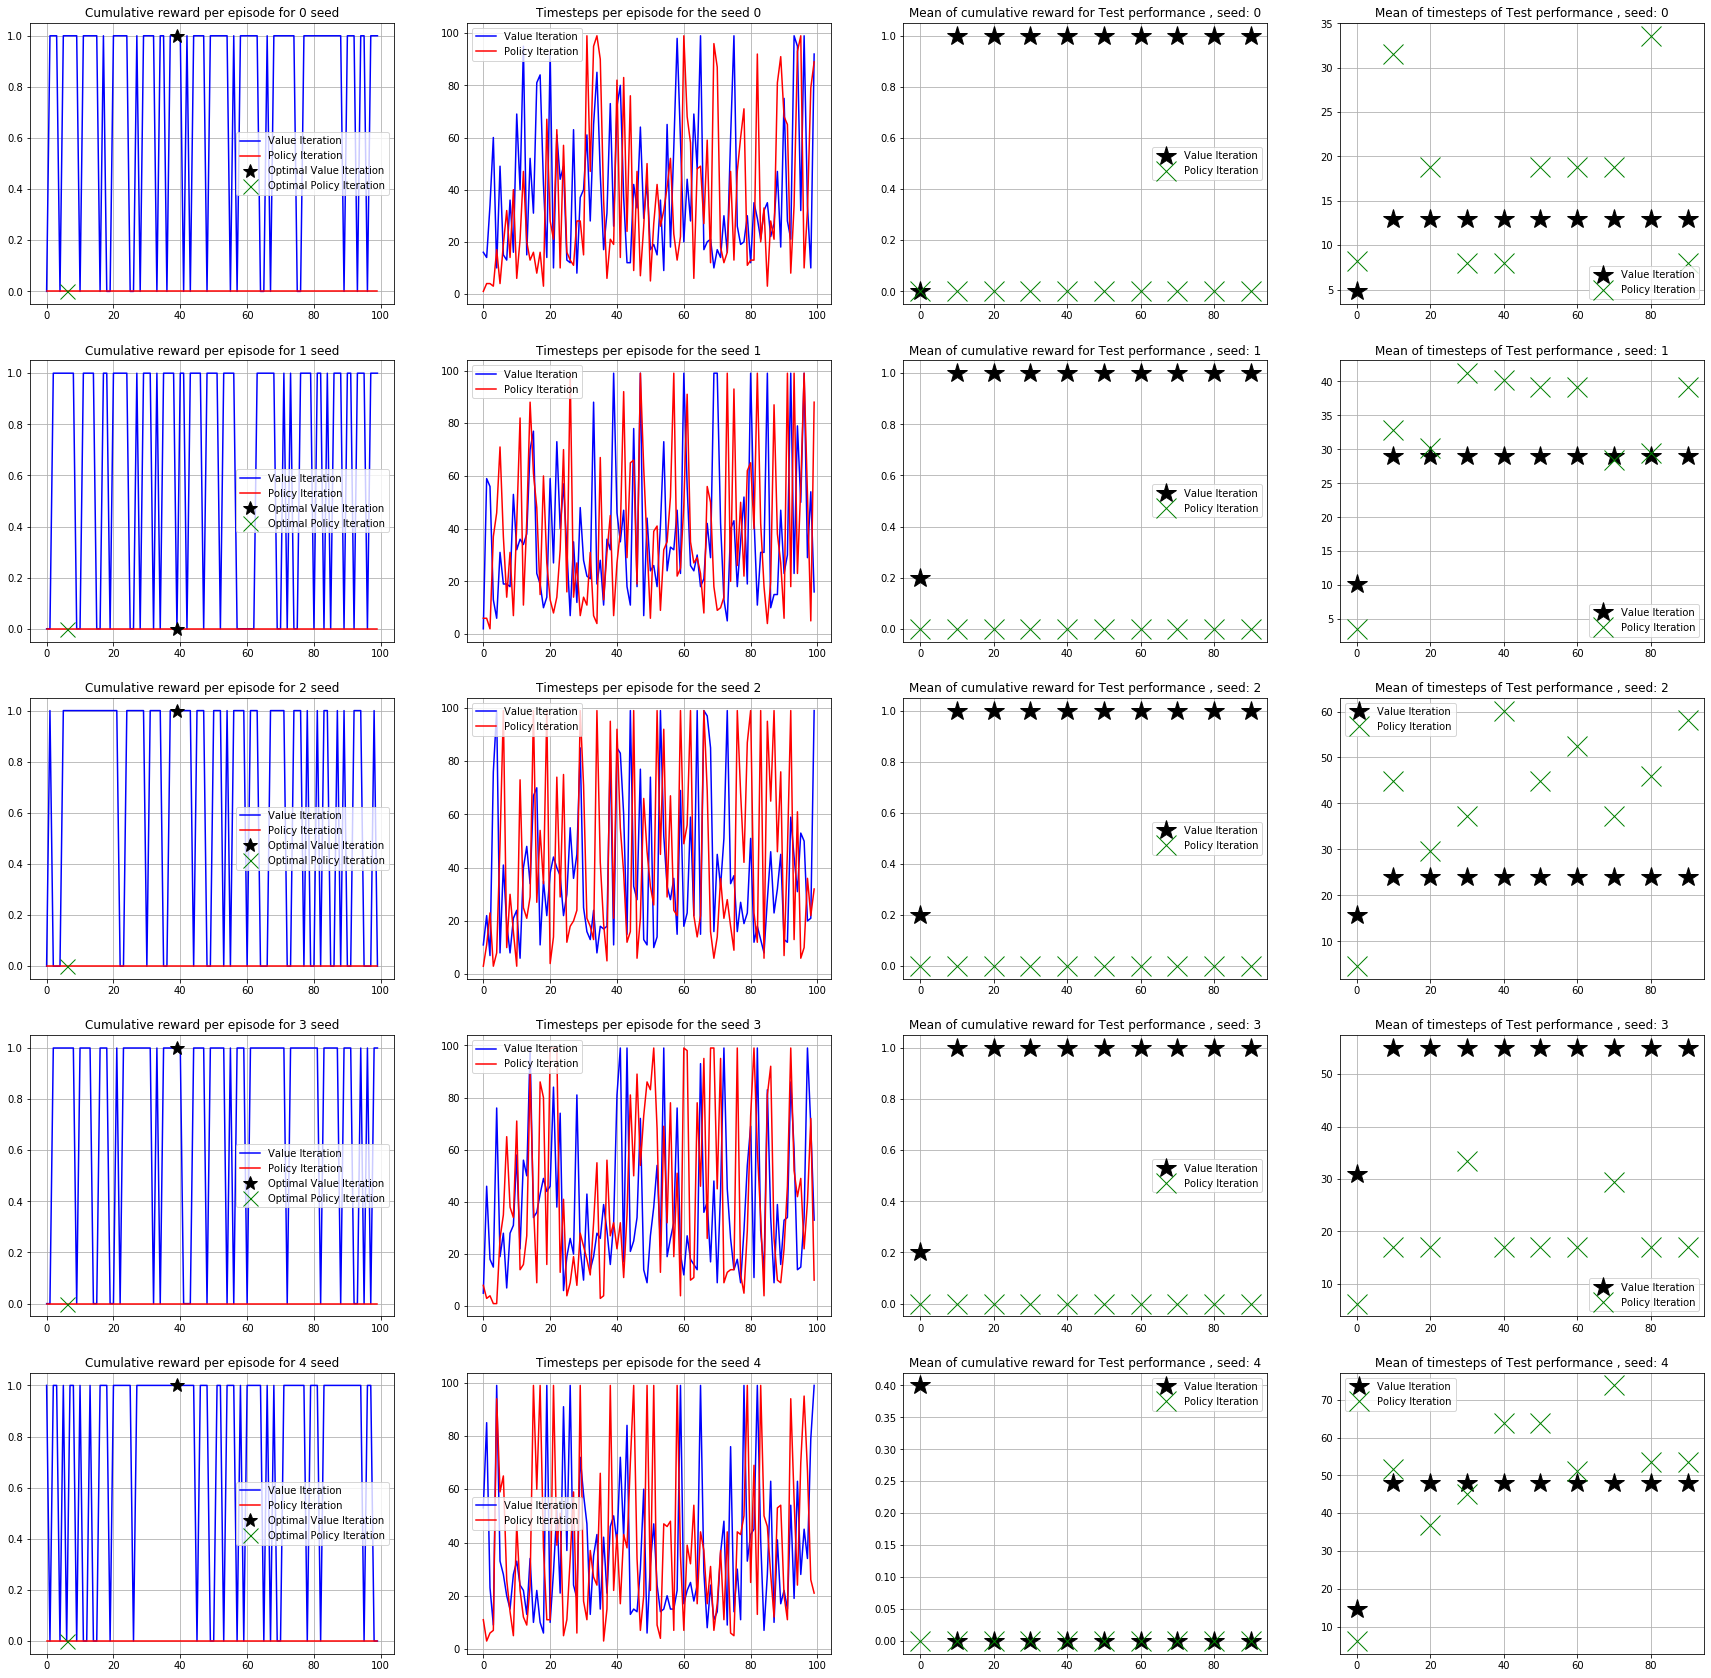

time: 8.96 s


In [154]:
#Frozen Lake Environnement 1
play_game('FrozenLake-v0',episode=100,timesteps=100,fixed_seeds_nb=5,
           policy_evaluation_episode=5,
           value_iteration_episode=5,
           discount=0.9) 

# Frozen Lake

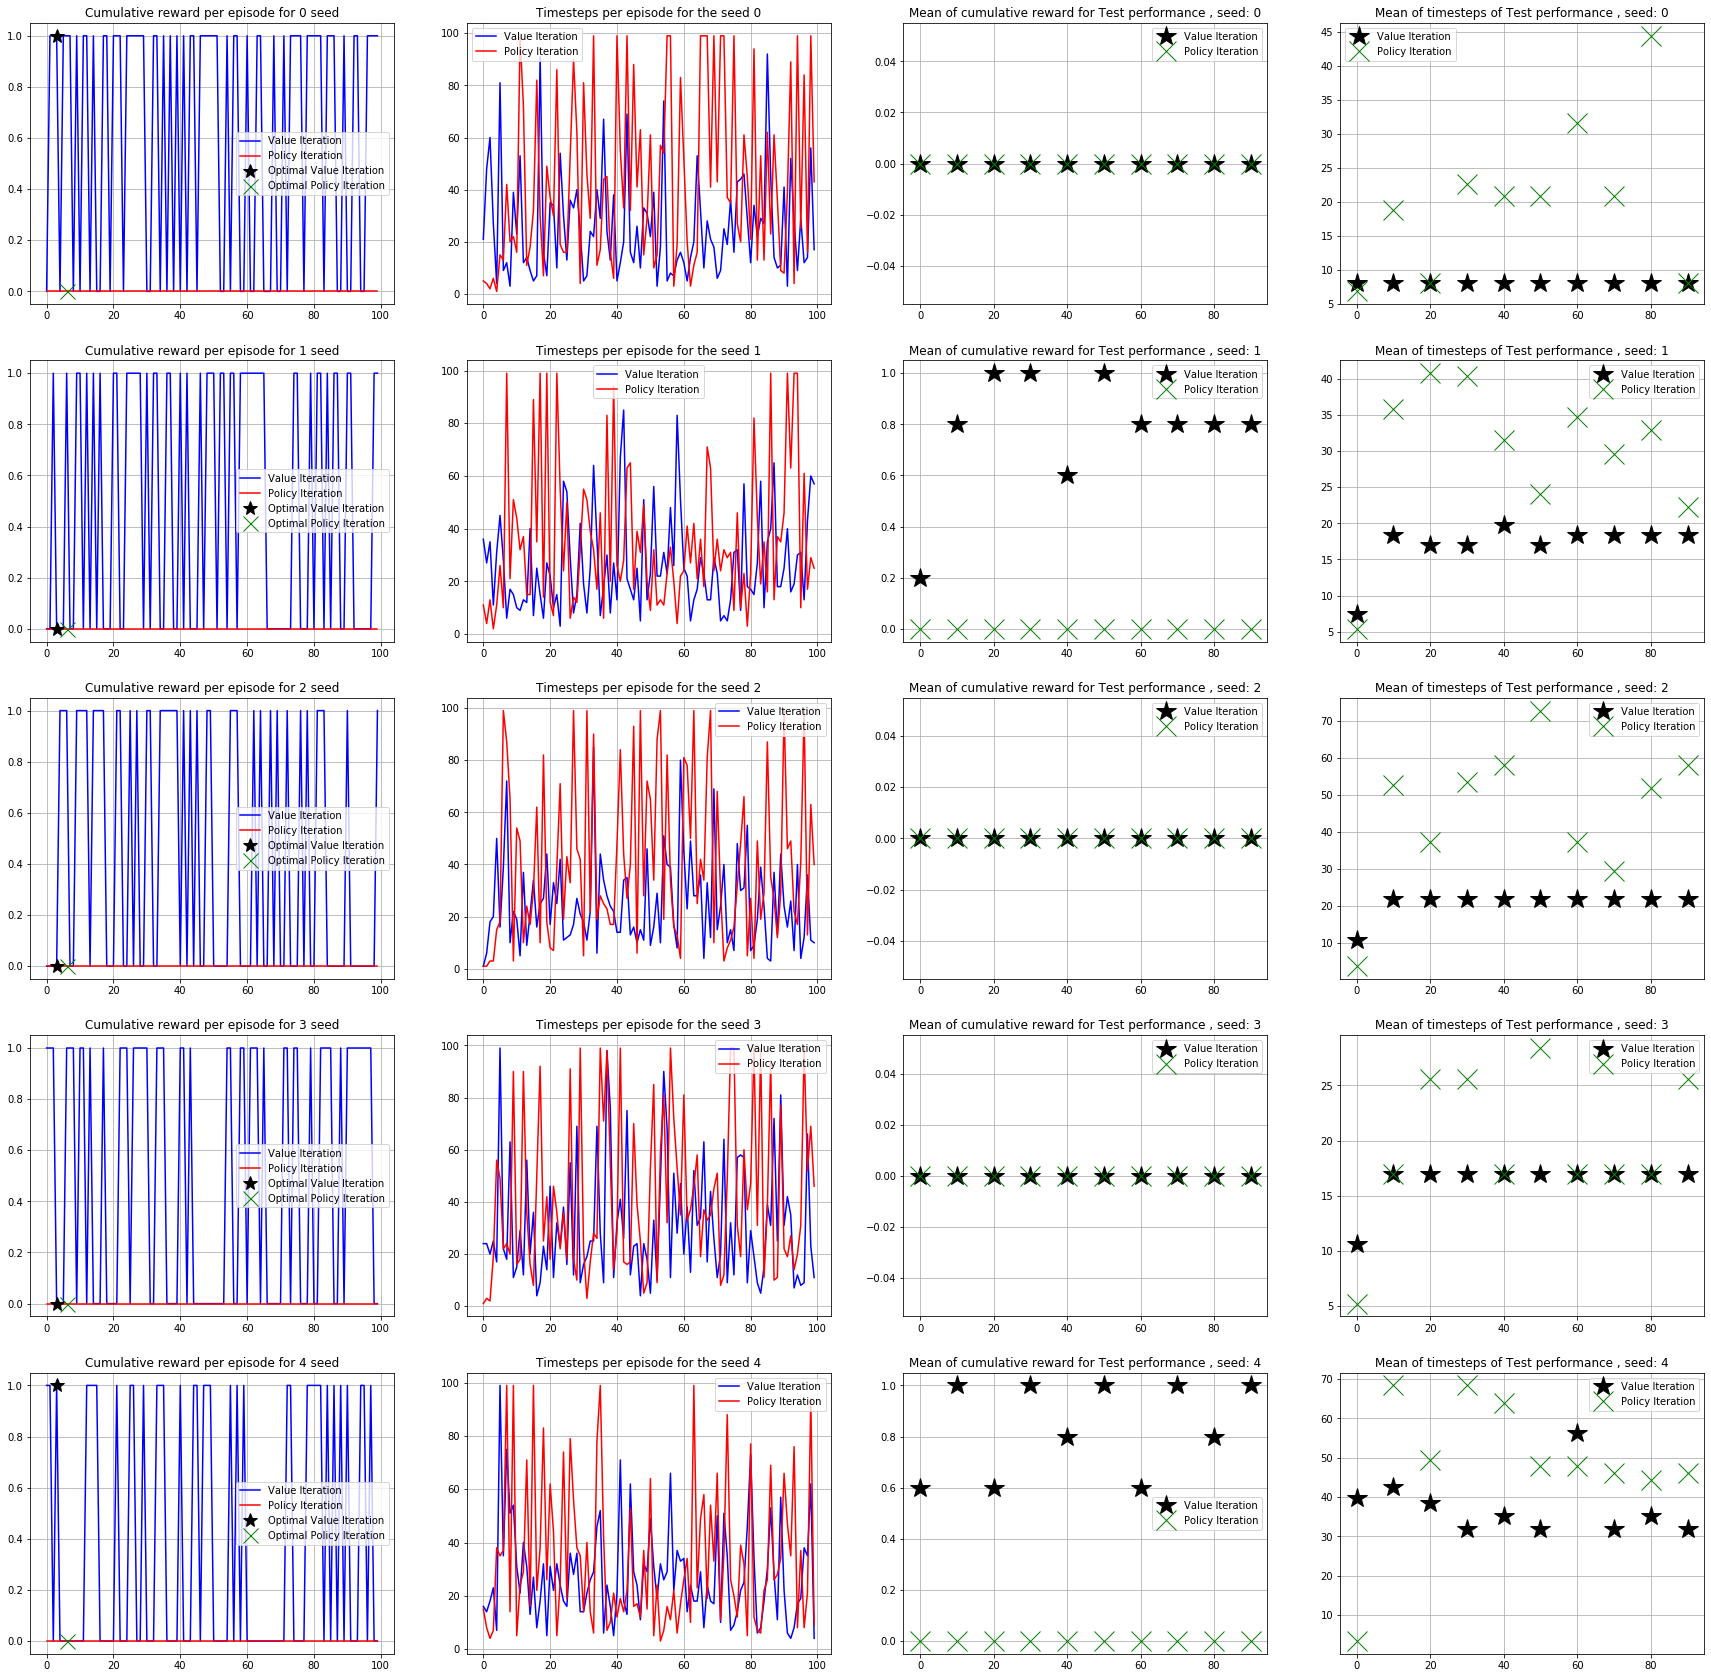

time: 7.33 s


In [155]:
#Frozen Lake Environnement 2 
play_game('FrozenLake-v0',episode=100,timesteps=100,fixed_seeds_nb=5,
           policy_evaluation_episode=5,
           value_iteration_episode=5,
           discount=.1) 

# Taxi

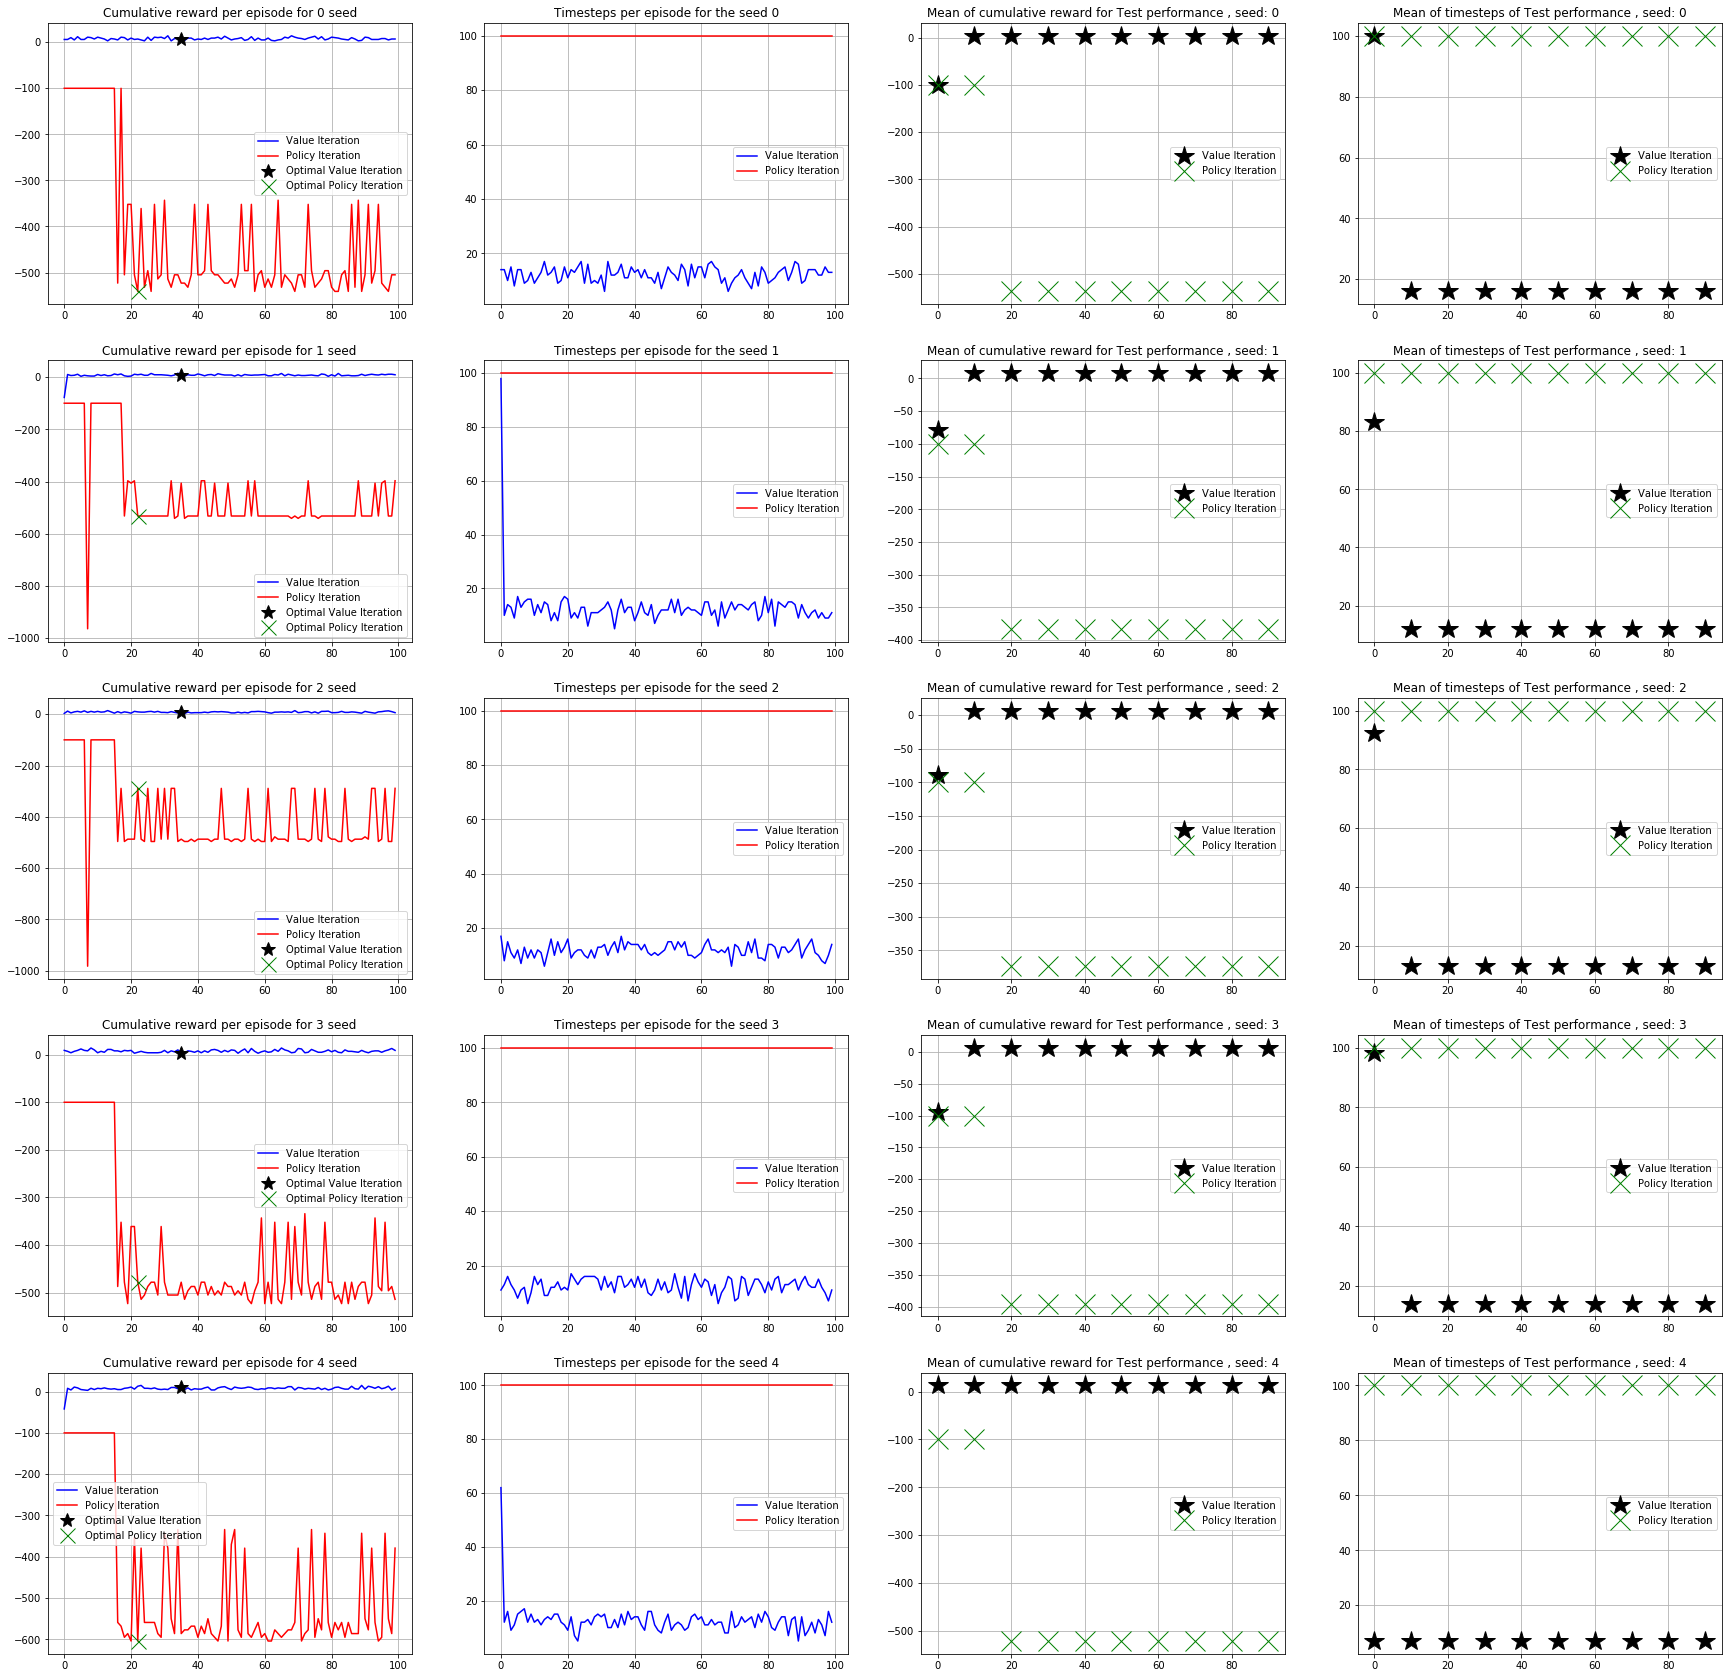

time: 54.3 s


In [156]:
#Taxi Environnement 1
play_game('Taxi-v3',episode=100,timesteps=100,fixed_seeds_nb=5,
           policy_evaluation_episode=5,
           value_iteration_episode=5,
           discount=0.9) 

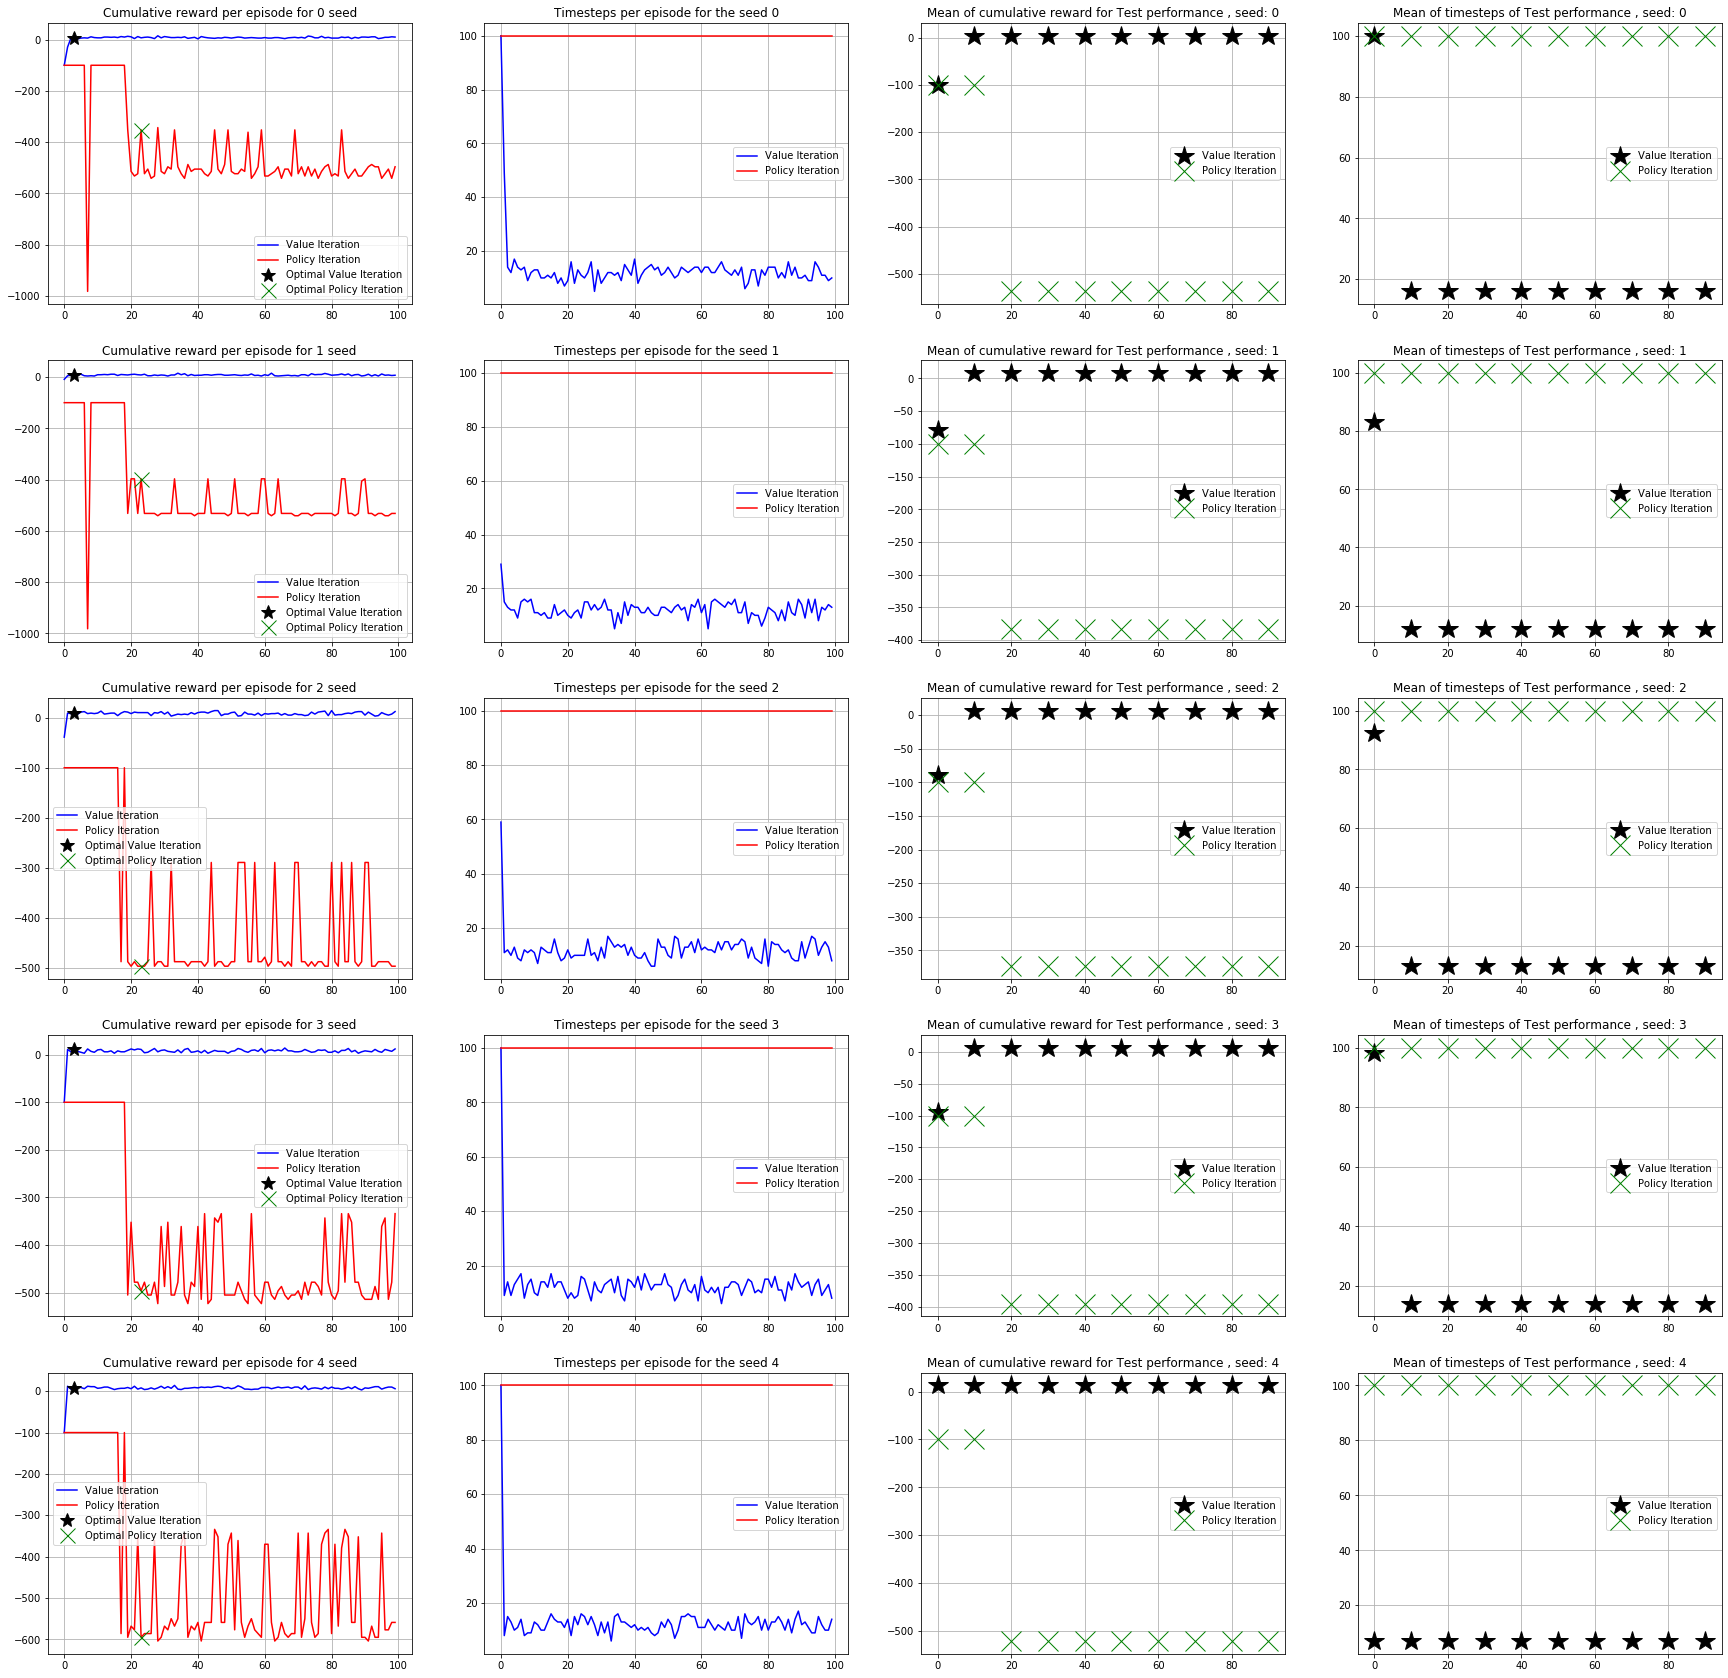

time: 21 s


In [157]:
#Taxi Environnement 2 
play_game('Taxi-v3',episode=100,timesteps=100,fixed_seeds_nb=5,
           policy_evaluation_episode=5,
           value_iteration_episode=5,
           discount=.1) 

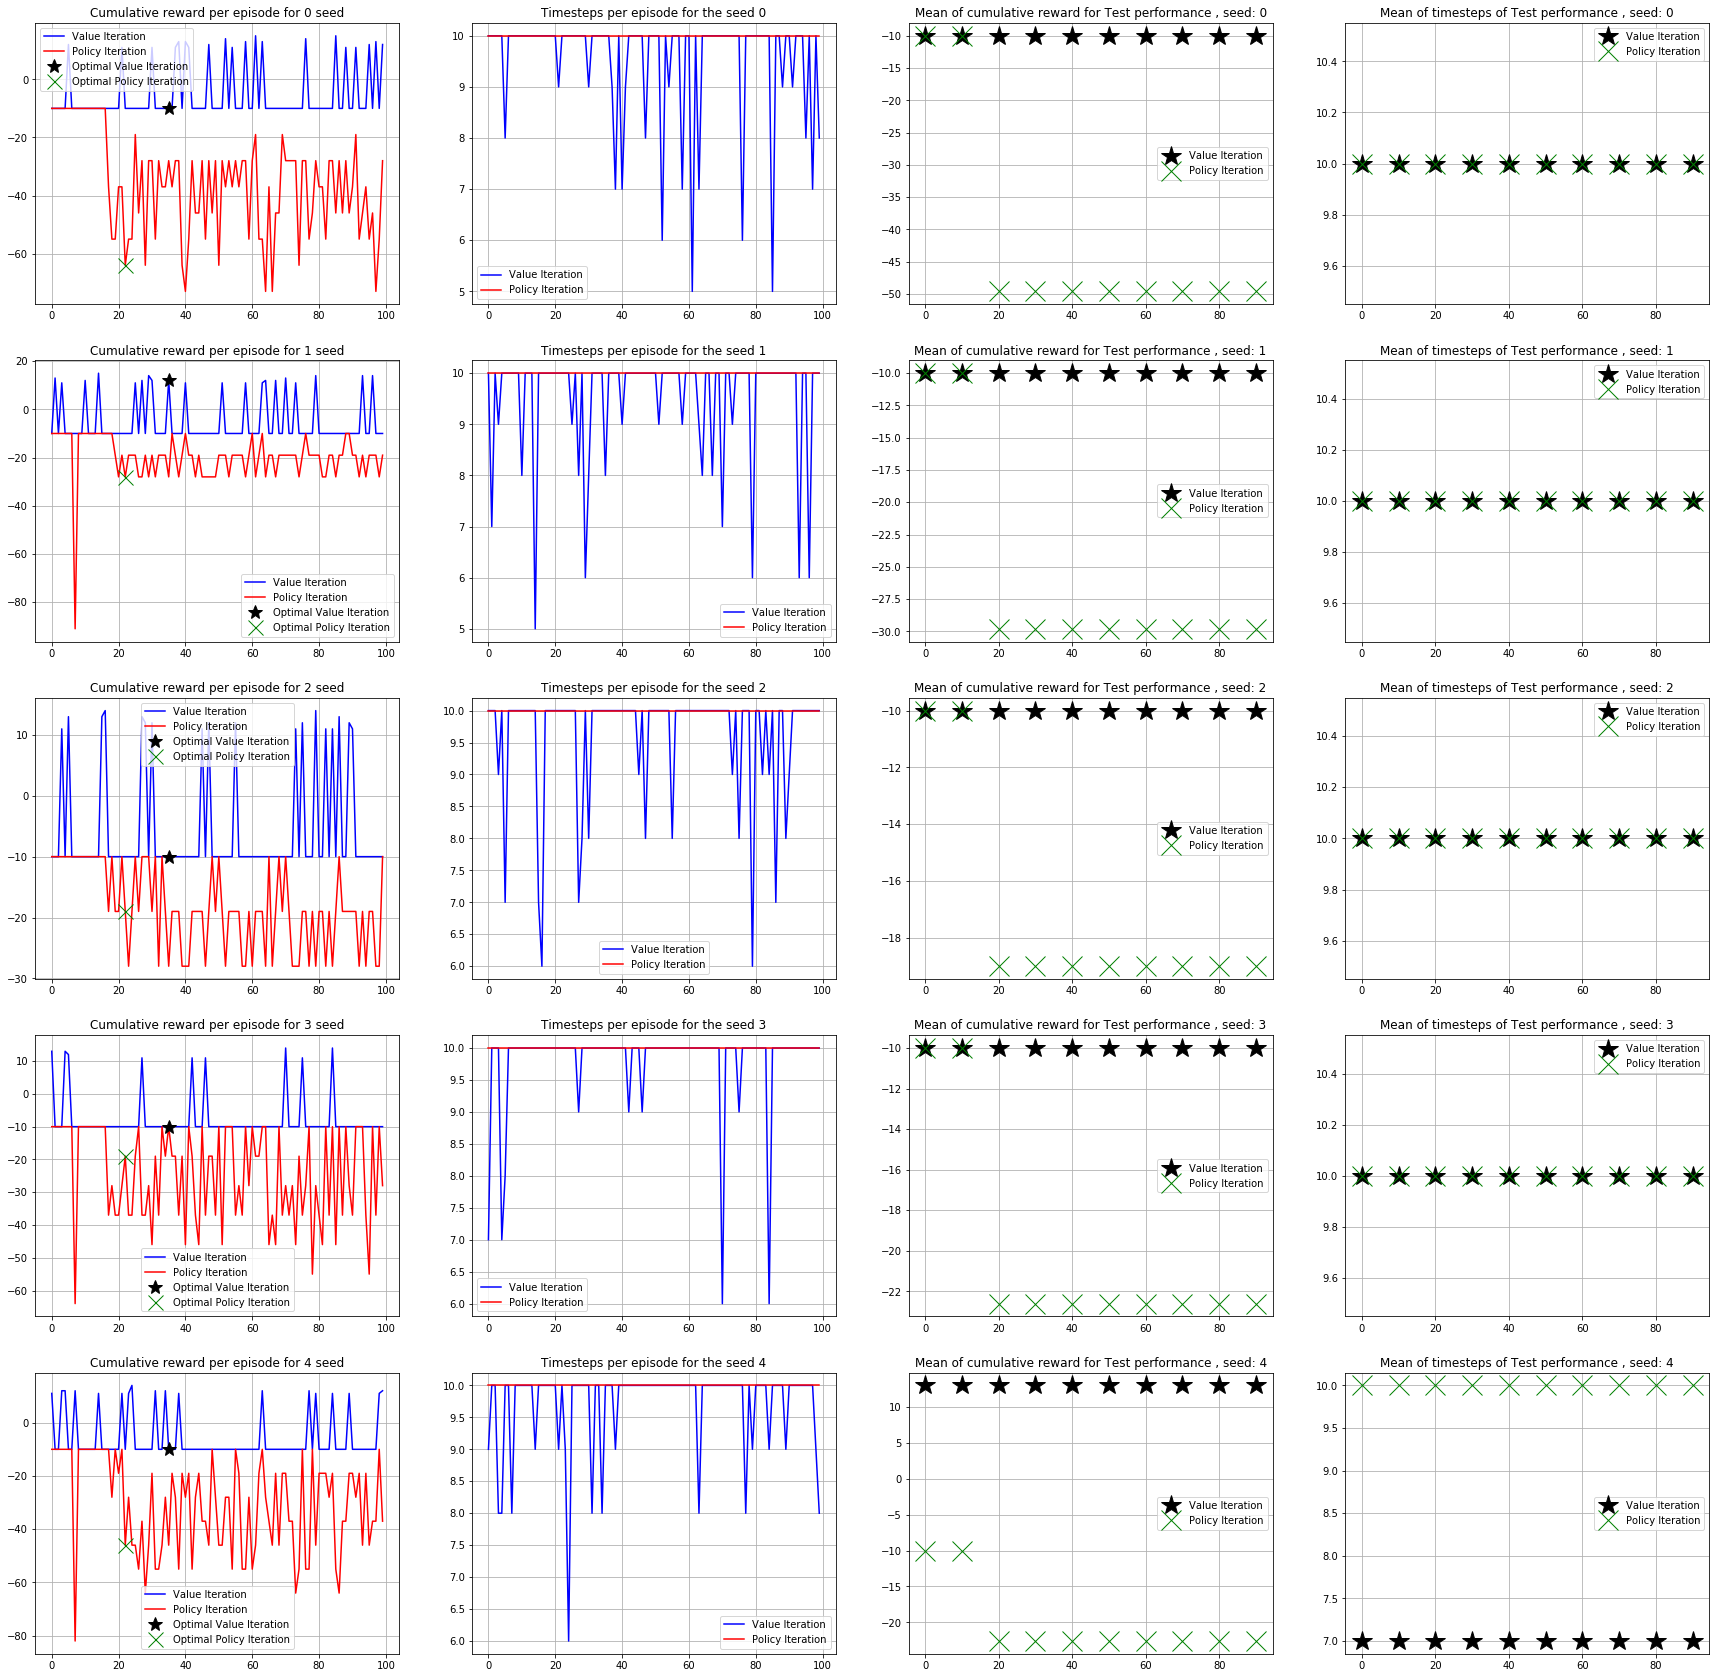

time: 50.5 s


In [158]:
#Taxi Environnement 3
play_game('Taxi-v3',episode=100,timesteps=10,fixed_seeds_nb=5,
           policy_evaluation_episode=5,
           value_iteration_episode=5,
           discount=0.9) 

# Conclusion

We realize that the discount factor play a determinant role on the convergence speed, especially for Policy iteration. Indeed, since the initialized policy is randomized, by an increase of the discount factor, the algorithm waits until it tottaly converges, as a consequence it may stuck between two or more equally good polices.

Secondly, lowering the maximum step for convergence required by episode shows that Policy iteration produce lower rewards than value iteration. This is due to the fact that Policy iteration suggest spending more time for better evaluate the policy. This is would be more profitable if we are looking for long run profitable reward versus fast convergence for Value iteration.  
